In [15]:
import numpy as np
import pandas as pd
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline

In [16]:
def standardize_data(df:pd.DataFrame, gaussian:list= [], uniform:list= [], skewed:list= []):
    # create transformers
    gaussian_transformer = StandardScaler()
    uniform_transformer = MinMaxScaler()
    skewed_transformer = Pipeline(steps=[
        ('log', FunctionTransformer(np.log1p)),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('gaussian', gaussian_transformer, gaussian),
        ('uniform', uniform_transformer, uniform),
        ('skewed', skewed_transformer, skewed)
    ])

    transformed_data = preprocessor.fit_transform(df)

    # back to df with original column names
    transformed_df = pd.DataFrame(
        transformed_data,
        columns= gaussian + uniform + skewed
    )

    return transformed_df

Feature Importances:
                feature  importance
9   past_da_price_error    0.160169
6        past_spikes_30    0.133225
8    past_da_load_error    0.131587
7   load_capacity_ratio    0.130488
10           wind_speed    0.130227
4                   hdd    0.089501
2                  hour    0.084425
5                   cdd    0.064561
3                 month    0.049004
0            is_weekend    0.014425
11        precipitation    0.012317
1            is_holiday    0.000071
Random Forest AUC: 0.8589


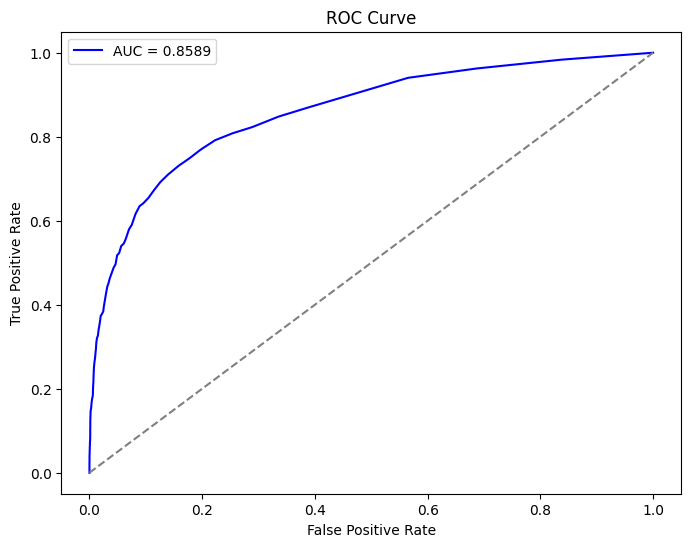

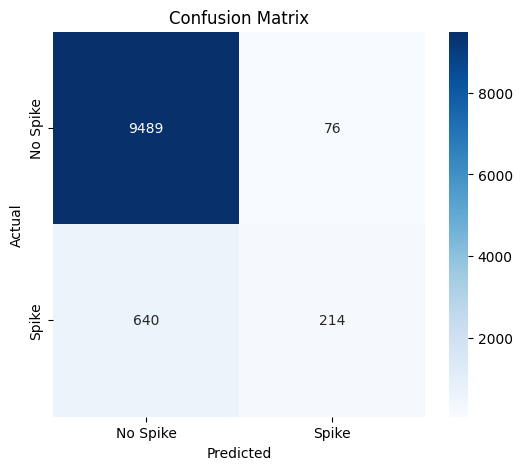

In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
root = '../data/'
path = 'ml_features.csv'

df = pd.read_csv(os.path.join(root,path))
df.dropna(inplace=True)
# Split data into train and test sets
target_col = "spike_30"  # Replace with your target column name
y = df[target_col]
# Drop rows with NaN values resulting from lag feature creation

gaussian = []
uniform = ['is_weekend', 'is_holiday', 'hour', 'month']
skewed = ['hdd', 'cdd', 'past_spikes_30', 'load_capacity_ratio', 'past_da_load_error', 'past_da_price_error',
            'wind_speed', 'precipitation']

# Standardize features
df = standardize_data(df, gaussian, uniform, skewed)

features = [col for col in df.columns if col not in ["date", target_col]]

X = df[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get predicted probabilities for the positive class (1)
y_probs = rf_model.predict_proba(X_test)[:, 1]

feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)
print("Feature Importances:")
print(feature_importances)

# Compute AUC
auc = roc_auc_score(y_test, y_probs)
print(f"Random Forest AUC: {auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Compute Confusion Matrix
y_pred = (y_probs >= 0.5).astype(int)  # Convert probabilities to binary predictions
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Spike", "Spike"], yticklabels=["No Spike", "Spike"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
